In [1]:
from pathlib import Path
from typing import List, Dict

import numpy as np
import torch
import yaml
from torch.utils.data import DataLoader

from dataset import get_dataset
from models import VAE, AE
from seed import get_seeded_generator, seed_everything, seeded_worker_init_fn
from visualizations import (plot_latent_space_in_2d)

In [2]:
vae_config = "configs/VAE/MNIST/latent-dim-ablation/latent_dim=2.yaml"
vae_ckpt = "checkpoints/MNIST/VAE(latent_dim=2)/best.ckpt"

In [3]:
with open(vae_config, "r") as fs:
    vae_config = yaml.safe_load(fs)

In [4]:
ae_config = "configs/AE/MNIST/latent_dim=2.yaml"
ae_ckpt = "checkpoints/MNIST/AE(latent_dim=2)/best.ckpt"

In [5]:
with open(ae_config, "r") as fs:
    ae_config = yaml.safe_load(fs)

In [6]:
device = torch.device("mps")
seed_everything(vae_config["training"]["seed"])

In [7]:
# Load model
vae = VAE(
    image_channels=vae_config["image"]["channels"],
    image_size=(
        vae_config["image"]["size"],
        vae_config["image"]["size"]
    ),
    **vae_config["model"]
)
vae.load_state_dict(
    torch.load(vae_ckpt, map_location=device)["model_state_dict"]
)

<All keys matched successfully>

In [8]:
# Load model
ae = AE(
    image_channels=ae_config["image"]["channels"],
    image_size=(
        ae_config["image"]["size"],
        ae_config["image"]["size"]
    ),
    **ae_config["model"]
)
ae.load_state_dict(
    torch.load(ae_ckpt, map_location=device)["model_state_dict"]
)

<All keys matched successfully>

In [9]:
# Load datasets
train_dataset, test_dataset = get_dataset(
    vae_config["dataset"]["name"],
    Path(vae_config["dataset"]["datasets_dir"]),
    vae_config["image"]["size"]
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=vae_config["training"]["batch_size"],
    worker_init_fn=seeded_worker_init_fn,
    generator=get_seeded_generator(vae_config["training"]["seed"]),
    num_workers=vae_config["training"]["num_workers"],
    prefetch_factor=(
        vae_config["training"]["prefetch_factor"] if vae_config["training"]["prefetch_factor"] else None
    ),
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=vae_config["training"]["batch_size"],
    worker_init_fn=seeded_worker_init_fn,
    generator=get_seeded_generator(vae_config["training"]["seed"]),
    num_workers=vae_config["training"]["num_workers"],
    prefetch_factor=(
        vae_config["training"]["prefetch_factor"] if vae_config["training"]["prefetch_factor"] else None
    ),
)

In [10]:
def get_latents(model: VAE, dataloader: DataLoader, device=torch.device) -> torch.Tensor:
    model = model.to(device)
    model.eval()

    zs: List[torch.Tensor] = []

    with torch.inference_mode():
        for x, _ in iter(dataloader):
            x = x.to(device)
            q = model.encode(x)
            z = q.sample()
            zs.append(z)

    zs = torch.cat(zs, dim=0)
    return zs

In [11]:
x_train = np.array([x for x, _ in train_dataset]).reshape((-1, 28 * 28))
x_test = np.array([x for x, _ in test_dataset]).reshape((-1, 28 * 28))

y_train = np.array([y for _, y in train_dataset])
y_test = np.array([y for _, y in test_dataset])

### VAE Latents

In [12]:
z_train_vae = get_latents(vae, train_dataloader, device)
z_test_vae = get_latents(vae, test_dataloader, device)

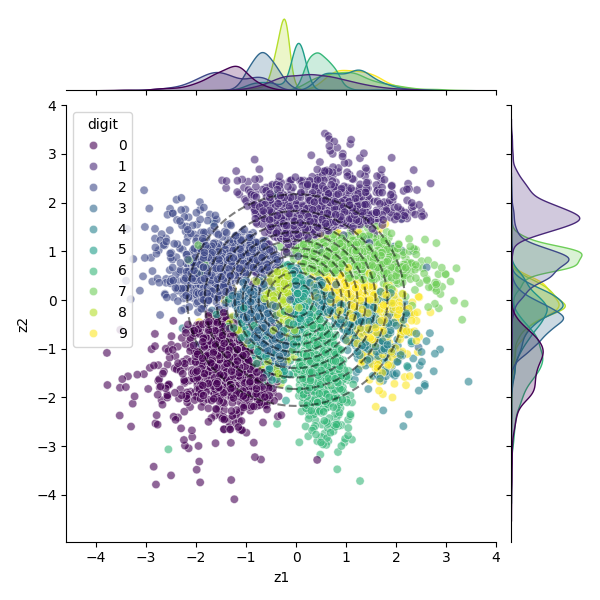

In [13]:
plot_latent_space_in_2d(
    embeddings=z_test_vae.cpu().numpy(),
    labels=y_test,
    hue="digit"
)

### AE Latents

In [14]:
z_train_ae = get_latents(ae, train_dataloader, device)
z_test_ae = get_latents(ae, test_dataloader, device)

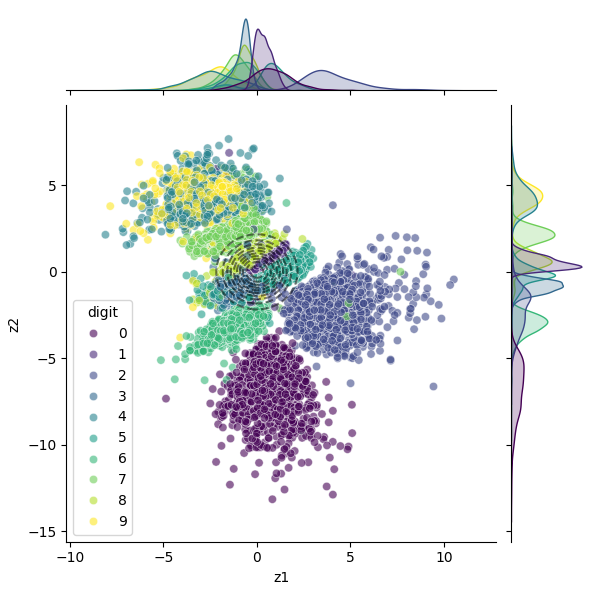

In [15]:
plot_latent_space_in_2d(
    embeddings=z_test_ae.cpu().numpy(),
    labels=y_test,
    hue="digit"
)

### PCA Latents

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(x_train)

z_train_pca = pca.transform(x_train)
z_test_pca = pca.transform(x_test)

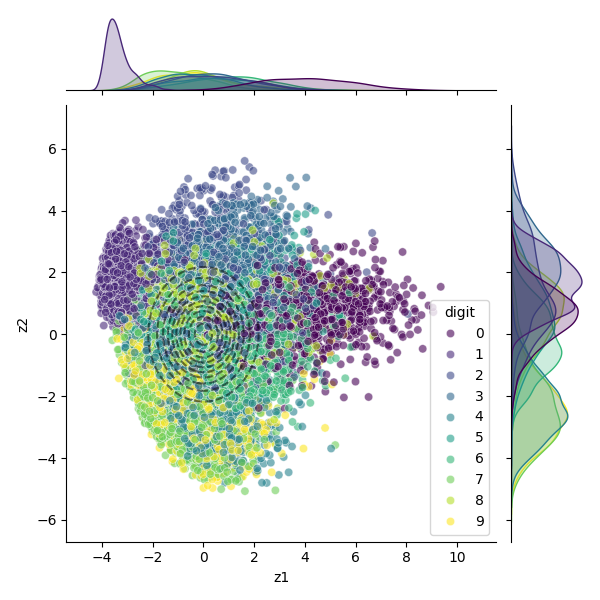

In [17]:
plot_latent_space_in_2d(
    embeddings=z_test_pca,
    labels=y_test,
    hue="digit"
)

### UMAP Latents

In [18]:
from umap import UMAP

umap = UMAP(n_components=2)
umap.fit(x_train)

z_train_umap = umap.transform(x_train)
z_test_umap = umap.transform(x_test)

/Users/gboduljak/.local/share/virtualenvs/vae-omviI8RM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


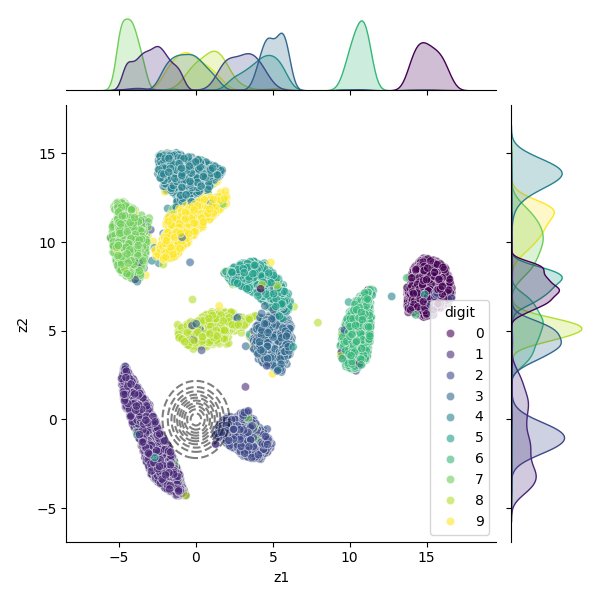

In [19]:
plot_latent_space_in_2d(
    embeddings=z_test_umap,
    labels=y_test,
    hue="digit"
)

### Classifier Evaluation

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

classifiers = {
    "Logistic Regression": LogisticRegression(
        random_state=vae_config["training"]["seed"],
        max_iter=1000
    ),
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "Naive Bayes": GaussianNB()
}
latents = {
    "VAE": [
        z_train_vae.cpu().numpy(),
        z_test_vae.cpu().numpy()
    ],
    "AE": [
        z_train_ae.cpu().numpy(),
        z_test_ae.cpu().numpy()
    ],
    "PCA": [z_train_pca, z_test_pca],
    "UMAP": [z_train_umap, z_test_umap]
}

In [21]:
results: List[Dict[str, str]] = []

for encoder, [z_train, z_test] in latents.items():
    for name, clf in classifiers.items():
        clf.fit(z_train, y_train)
        accuracy = accuracy_score(y_test, clf.predict(z_test))
        f1 = f1_score(y_test, clf.predict(z_test), average="macro")
        results.append({
            "Model": name,
            "Latents": encoder,
            "Accuracy": accuracy,
            "F1 Score": f1
        })

results_df = pd.DataFrame(results)
results_df

,Model,Latents,Accuracy,F1 Score
0,Logistic Regression,VAE,0.7693,0.757242
1,KNN,VAE,0.8204,0.817333
2,Naive Bayes,VAE,0.7758,0.762586
3,Logistic Regression,AE,0.8260,0.808383
4,KNN,AE,0.8577,0.856372
5,Naive Bayes,AE,0.7672,0.754210
6,Logistic Regression,PCA,0.4460,0.387646
7,KNN,PCA,0.4033,0.375699
8,Naive Bayes,PCA,0.4459,0.366149
9,Logistic Regression,UMAP,0.9531,0.952972


<Axes: xlabel='Model', ylabel='F1 Score'>

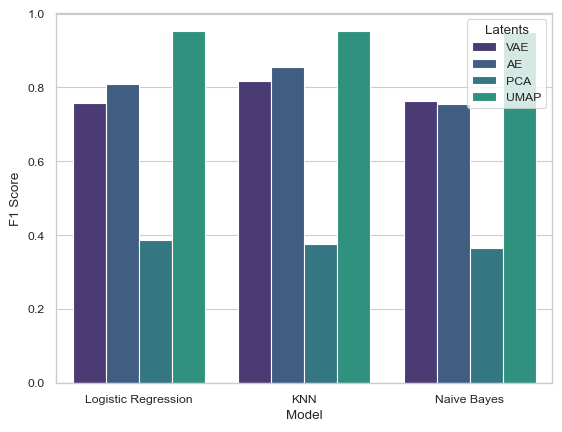

In [22]:
import seaborn as sns

sns.set_palette("viridis")
sns.set_style("whitegrid")
sns.set_context("paper")

sns.barplot(
    data=results_df,
    x="Model",
    y="F1 Score",
    hue="Latents"
)